
# BCI Motor Imagery: LOSO CV + CSP/LDA vs EEGNet (MNE + PyTorch + Optuna)

Этот ноутбук:
- Загружает EEGBCI (PhysioNet) для моторного воображения (рука/рука).
- Делает препроцессинг в MNE с опцией baseline.
- Считает baseline **CSP+LDA** и сравнивает с **EEGNet (PyTorch)**.
- Реализует **Leave-One-Subject-Out (LOSO)** и **Optuna** для HPO.
- Исправлены ошибки:
  - Лейблы ремапятся в **[0..K-1]** на каждом LOSO-сплите.
  - В тесте удаляются сэмплы классов, которых нет в трейне (типичная проблема LOSO).
  - **Optuna**: `suggest_float(..., log=True)` вместо `suggest_loguniform`.
  - Безопасный перенос на GPU с **fallback на CPU** при ошибках CUDA.


In [1]:

# %pip install mne torch scikit-learn optuna matplotlib

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
from mne.datasets import eegbci
from mne import Epochs, pick_types, events_from_annotations
from mne.decoding import CSP

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import optuna

warnings.filterwarnings("ignore", category=RuntimeWarning)
print("Versions -> mne:", mne.__version__, "| torch:", torch.__version__, "| optuna:", optuna.__version__)


Versions -> mne: 1.10.0 | torch: 2.7.1+cu118 | optuna: 4.5.0


In [2]:

class CFG:
    # Быстрый демо-набор; можно расширить (например, subjects=range(1,10))
    subjects = [1, 2, 3]
    runs = [4, 8, 12]         # MI runs (left/right hand imagery)
    data_path = None          # путь к данным EEGBCI (None => mne сам скачает в MNE_DATA)
    
    # Препроцессинг
    sfreq = 128
    l_freq = 7.0
    h_freq = 30.0
    tmin = 1.0
    tmax = 4.0
    use_baseline = False      # если True: tmin=-0.2, baseline=(None, 0)
    
    # Обучение (EEGNet)
    batch_size = 32
    epochs = 6                # увеличьте для лучшего качества
    lr = 1e-3
    random_state = 42
    
    # Optuna
    optuna_trials = 3         # увеличьте для реального HPO
    quick_debug = False       # True => случайная подс выборки для ускорения

cfg = CFG()

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(cfg.random_state)

def get_device_safe():
    try:
        if torch.cuda.is_available():
            return torch.device("cuda")
        return torch.device("cpu")
    except Exception:
        return torch.device("cpu")

device = get_device_safe()
device


device(type='cuda')

## Загрузка и препроцессинг

In [3]:

def load_preprocess(subject=1, runs=[4,8,12], data_path=None, verbose=False):
    # Загрузка
    fnames = eegbci.load_data(subject, runs, path=data_path, verbose=verbose)
    raws = [mne.io.read_raw_edf(f, preload=True, stim_channel='auto', verbose=False) for f in fnames]
    raw = mne.concatenate_raws(raws, verbose=False)
    
    # Препроцессинг
    raw.resample(cfg.sfreq, npad='auto')
    raw.filter(cfg.l_freq, cfg.h_freq, fir_design='firwin', verbose=False)
    
    # События
    events, _ = events_from_annotations(raw)
    event_id = {'left': 2, 'right': 3}  # EEGBCI labels
    
    picks = pick_types(raw.info, eeg=True, exclude='bads')
    
    tmin, tmax = cfg.tmin, cfg.tmax
    baseline = None
    if cfg.use_baseline:
        tmin = -0.2
        baseline = (None, 0)
    
    epochs = Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    picks=picks, baseline=baseline, preload=True, verbose=False)
    
    X = epochs.get_data()                 # (n_epochs, n_channels, n_times)
    y_raw = epochs.events[:, -1]         # {2,3}
    return X, y_raw, epochs, raw


## Утилиты для меток (чтобы избежать CUDA assert)

In [4]:

def encode_labels_train_test(y_train, y_test):
    """Обучаем LabelEncoder на train-метках.
    Фильтруем тестовые сэмплы, классов которых нет в трейне.
    Возвращаем: y_train_enc, y_test_enc, test_mask, n_classes, encoder
    """
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    test_mask = np.isin(y_test, le.classes_)
    y_test_valid = y_test[test_mask]
    y_test_enc = le.transform(y_test_valid)
    n_classes = len(le.classes_)
    return y_train_enc, y_test_enc, test_mask, n_classes, le

def zscore_epochs(X):
    X = X.astype(np.float32)
    mean = X.mean(axis=(1,2), keepdims=True)
    std = X.std(axis=(1,2), keepdims=True) + 1e-6
    return (X - mean) / std


In [5]:

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(zscore_epochs(X))
        self.y = torch.from_numpy(y.astype(np.int64))
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        # Conv2d ждёт (N, 1, C, T)
        return self.X[idx].unsqueeze(0), self.y[idx]


In [6]:

class EEGNet(nn.Module):
    def __init__(self, n_channels, n_times, n_classes=2, F1=16, D=2, dropout=0.5):
        super().__init__()
        self.n_classes = n_classes
        
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, 51), padding=(0,25), bias=False),
            nn.BatchNorm2d(F1)
        )
        self.depthwise = nn.Sequential(
            nn.Conv2d(F1, F1*D, kernel_size=(n_channels,1), groups=F1, bias=False),
            nn.BatchNorm2d(F1*D),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,4)),
            nn.Dropout(dropout)
        )
        self.separable = nn.Sequential(
            nn.Conv2d(F1*D, F1*D, kernel_size=(1,15), padding=(0,7), bias=False),
            nn.BatchNorm2d(F1*D),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,8)),
            nn.Dropout(dropout)
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(F1*D, n_classes)
        )
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwise(x)
        x = self.separable(x)
        x = self.head(x)
        return x


In [7]:

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    # Пробуем CUDA, при ошибке перекидываем на CPU
    try:
        use_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(use_device)
    except Exception as e:
        print("CUDA init failed -> CPU fallback:", repr(e))
        use_device = torch.device("cpu")
        model = model.to(use_device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(use_device), yb.to(use_device)
            # Safety check
            if yb.min() < 0 or yb.max() >= model.n_classes:
                raise ValueError(f"Bad labels in batch: min={yb.min().item()}, max={yb.max().item()}, "
                                 f"expected within [0..{model.n_classes-1}]")
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
        
        # quick val
        model.eval(); correct=0; total=0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(use_device), yb.to(use_device)
                preds = model(xb).argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        print(f"Epoch {ep+1}/{epochs} | val acc = {correct/max(total,1):.3f}")
    return model


In [8]:
def csp_lda_fit_predict(X_train, y_train, X_test, n_components=6):
    csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)
    Xtr = csp.fit_transform(X_train, y_train)
    clf = LDA().fit(Xtr, y_train)
    Xte = csp.transform(X_test)
    return clf.predict(Xte)


## LOSO + Optuna + сравнение моделей

In [9]:

def loso_experiment(subjects, runs, optuna_trials=3):
    results = []
    for test_subject in subjects:
        print(f"=== LOSO: left-out subject {test_subject} ===")
        # load train subjects
        X_train_list, y_train_list = [], []
        for s in subjects:
            if s == test_subject: continue
            Xs, ys, _, _ = load_preprocess(s, runs, data_path=cfg.data_path, verbose=False)
            if cfg.quick_debug:
                idx = np.random.choice(len(ys), min(200, len(ys)), replace=False)
                Xs, ys = Xs[idx], ys[idx]
            X_train_list.append(Xs); y_train_list.append(ys)
        X_train_all = np.concatenate(X_train_list); y_train_all = np.concatenate(y_train_list)
        
        # load test subject
        X_test, y_test, _, _ = load_preprocess(test_subject, runs, data_path=cfg.data_path, verbose=False)
        if cfg.quick_debug:
            idx = np.random.choice(len(y_test), min(120, len(y_test)), replace=False)
            X_test, y_test = X_test[idx], y_test[idx]
        
        # Encode labels & filter unseen test classes
        y_train_enc, y_test_enc, test_mask, n_classes, le = encode_labels_train_test(y_train_all, y_test)
        X_test_enc = X_test[test_mask]
        if len(X_test_enc) == 0:
            print("Skip: no overlapping classes between train and test")
            continue
        
        # Baseline CSP+LDA
        y_pred_csp = csp_lda_fit_predict(X_train_all, y_train_enc, X_test_enc, n_components=6)
        acc_csp = accuracy_score(y_test_enc, y_pred_csp)
        print(f"CSP+LDA acc: {acc_csp:.3f}")
        
        # Optuna HPO (EEGNet)
        def objective(trial):
            F1 = trial.suggest_categorical("F1", [8, 16, 32])
            D = trial.suggest_int("D", 1, 4)
            dropout = trial.suggest_float("dropout", 0.1, 0.7)
            lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
            batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
            
            train_ds = EEGDataset(X_train_all, y_train_enc)
            val_ds = EEGDataset(X_test_enc, y_test_enc)
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
            
            model = EEGNet(n_channels=X_train_all.shape[1], n_times=X_train_all.shape[2],
                           n_classes=n_classes, F1=F1, D=D, dropout=dropout)
            # Короткая тренировка на HPO
            ep = 3 if cfg.quick_debug else max(4, cfg.epochs//2)
            try:
                _ = train_model(model, train_loader, val_loader, epochs=ep, lr=lr)
            except RuntimeError as e:
                # Часто помогает fallback на CPU и повтор
                if "CUDA" in str(e):
                    print("CUDA error in trial -> retry on CPU")
                    torch.cuda.empty_cache()
                    _ = train_model(model.cpu(), train_loader, val_loader, epochs=ep, lr=lr)
                else:
                    raise
            # валидация
            mdl = model
            mdl.eval()
            with torch.no_grad():
                # оцениваем на вал-лоадере
                correct=0; total=0
                dev = next(mdl.parameters()).device
                for xb, yb in val_loader:
                    xb, yb = xb.to(dev), yb.to(dev)
                    preds = mdl(xb).argmax(1)
                    correct += (preds == yb).sum().item()
                    total += yb.size(0)
            return correct / max(total, 1)
        
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=optuna_trials)
        best = study.best_params
        
        # Train final EEGNet with best params
        train_ds = EEGDataset(X_train_all, y_train_enc)
        val_ds = EEGDataset(X_test_enc, y_test_enc)
        train_loader = DataLoader(train_ds, batch_size=best.get("batch_size", cfg.batch_size), shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=best.get("batch_size", cfg.batch_size), shuffle=False)
        
        model = EEGNet(n_channels=X_train_all.shape[1], n_times=X_train_all.shape[2],
                       n_classes=n_classes, F1=best.get("F1",16), D=best.get("D",2),
                       dropout=best.get("dropout",0.5))
        model = train_model(model, train_loader, val_loader, epochs=cfg.epochs, lr=best.get("lr", cfg.lr))
        
        # Final eval
        model.eval()
        dev = next(model.parameters()).device
        y_pred_nn = []
        with torch.no_grad():
            for xb, _yb in DataLoader(val_ds, batch_size=64, shuffle=False):
                xb = xb.to(dev)
                y_pred_nn.append(model(xb).argmax(1).cpu().numpy())
        y_pred_nn = np.concatenate(y_pred_nn)
        acc_nn = accuracy_score(y_test_enc, y_pred_nn)
        
        results.append({
            "left_out_subject": test_subject,
            "acc_csp_lda": acc_csp,
            "acc_eegnet": acc_nn,
            "best_params": best
        })
    return pd.DataFrame(results)

results_df = loso_experiment(cfg.subjects, cfg.runs, optuna_trials=cfg.optuna_trials)
results_df


=== LOSO: left-out subject 1 ===
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Computing rank from data with rank=None
    Using tolerance 0.00033 (2.2e-16 eps * 64 dim * 2.3e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


[I 2025-09-10 00:29:48,856] A new study created in memory with name: no-name-17fc6853-f697-4c25-8233-0a67b46411bf


CSP+LDA acc: 0.489
Epoch 1/4 | val acc = 0.511
Epoch 2/4 | val acc = 0.511
Epoch 3/4 | val acc = 0.511


[I 2025-09-10 00:29:52,135] Trial 0 finished with value: 0.5111111111111111 and parameters: {'F1': 32, 'D': 1, 'dropout': 0.45326550568397994, 'lr': 0.0005310229292330667, 'batch_size': 64}. Best is trial 0 with value: 0.5111111111111111.


Epoch 4/4 | val acc = 0.511
Epoch 1/4 | val acc = 0.511
Epoch 2/4 | val acc = 0.511


[I 2025-09-10 00:29:52,388] Trial 1 finished with value: 0.5111111111111111 and parameters: {'F1': 8, 'D': 1, 'dropout': 0.628796476003168, 'lr': 0.00048381132518390824, 'batch_size': 16}. Best is trial 0 with value: 0.5111111111111111.


Epoch 3/4 | val acc = 0.511
Epoch 4/4 | val acc = 0.511
Epoch 1/4 | val acc = 0.489
Epoch 2/4 | val acc = 0.489


[I 2025-09-10 00:29:52,673] Trial 2 finished with value: 0.4666666666666667 and parameters: {'F1': 16, 'D': 3, 'dropout': 0.6027513721661512, 'lr': 0.002814162377023089, 'batch_size': 64}. Best is trial 0 with value: 0.5111111111111111.


Epoch 3/4 | val acc = 0.489
Epoch 4/4 | val acc = 0.467
Epoch 1/6 | val acc = 0.511
Epoch 2/6 | val acc = 0.511
Epoch 3/6 | val acc = 0.511
Epoch 4/6 | val acc = 0.511
Epoch 5/6 | val acc = 0.511
Epoch 6/6 | val acc = 0.511
=== LOSO: left-out subject 2 ===
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Computing rank from data with rank=None
    Using tolerance 0.00039 (2.2e-16 eps * 64 dim * 2.7e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


[I 2025-09-10 00:29:56,116] A new study created in memory with name: no-name-69dc77c1-f8cd-4ee4-9ea8-158586f67744


CSP+LDA acc: 0.400
Epoch 1/4 | val acc = 0.489
Epoch 2/4 | val acc = 0.489
Epoch 3/4 | val acc = 0.489


[I 2025-09-10 00:29:56,523] Trial 0 finished with value: 0.4888888888888889 and parameters: {'F1': 16, 'D': 1, 'dropout': 0.49534327298078806, 'lr': 0.00038830662252659006, 'batch_size': 64}. Best is trial 0 with value: 0.4888888888888889.


Epoch 4/4 | val acc = 0.489
Epoch 1/4 | val acc = 0.511
Epoch 2/4 | val acc = 0.511
Epoch 3/4 | val acc = 0.511


[I 2025-09-10 00:29:56,842] Trial 1 finished with value: 0.5111111111111111 and parameters: {'F1': 16, 'D': 2, 'dropout': 0.26006937389886, 'lr': 0.0014034638480086622, 'batch_size': 64}. Best is trial 1 with value: 0.5111111111111111.


Epoch 4/4 | val acc = 0.511
Epoch 1/4 | val acc = 0.400
Epoch 2/4 | val acc = 0.533
Epoch 3/4 | val acc = 0.467


[I 2025-09-10 00:29:57,245] Trial 2 finished with value: 0.5333333333333333 and parameters: {'F1': 8, 'D': 4, 'dropout': 0.2879483359874494, 'lr': 0.0019704837498947347, 'batch_size': 16}. Best is trial 2 with value: 0.5333333333333333.


Epoch 4/4 | val acc = 0.533
Epoch 1/6 | val acc = 0.489
Epoch 2/6 | val acc = 0.489
Epoch 3/6 | val acc = 0.467
Epoch 4/6 | val acc = 0.422
Epoch 5/6 | val acc = 0.511
Epoch 6/6 | val acc = 0.444
=== LOSO: left-out subject 3 ===
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Computing rank from data with rank=None
    Using tolerance 0.00028 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


[I 2025-09-10 00:30:01,176] A new study created in memory with name: no-name-4426c9a9-6107-4b4c-b1c7-aef2a9144cb3


CSP+LDA acc: 0.489
Epoch 1/4 | val acc = 0.511
Epoch 2/4 | val acc = 0.444


[I 2025-09-10 00:30:02,076] Trial 0 finished with value: 0.4444444444444444 and parameters: {'F1': 32, 'D': 4, 'dropout': 0.3078819170449979, 'lr': 0.005522715661199732, 'batch_size': 16}. Best is trial 0 with value: 0.4444444444444444.


Epoch 3/4 | val acc = 0.444
Epoch 4/4 | val acc = 0.444
Epoch 1/4 | val acc = 0.489
Epoch 2/4 | val acc = 0.489


[I 2025-09-10 00:30:02,694] Trial 1 finished with value: 0.4888888888888889 and parameters: {'F1': 32, 'D': 4, 'dropout': 0.6963856027577339, 'lr': 0.000612197660938815, 'batch_size': 64}. Best is trial 1 with value: 0.4888888888888889.


Epoch 3/4 | val acc = 0.489
Epoch 4/4 | val acc = 0.489
Epoch 1/4 | val acc = 0.444
Epoch 2/4 | val acc = 0.489


[I 2025-09-10 00:30:03,314] Trial 2 finished with value: 0.4888888888888889 and parameters: {'F1': 32, 'D': 4, 'dropout': 0.6770655535751922, 'lr': 0.008293009768016718, 'batch_size': 16}. Best is trial 1 with value: 0.4888888888888889.


Epoch 3/4 | val acc = 0.489
Epoch 4/4 | val acc = 0.489
Epoch 1/6 | val acc = 0.511
Epoch 2/6 | val acc = 0.400
Epoch 3/6 | val acc = 0.444
Epoch 4/6 | val acc = 0.467
Epoch 5/6 | val acc = 0.467
Epoch 6/6 | val acc = 0.467


,left_out_subject,acc_csp_lda,acc_eegnet,best_params
0,1,0.488889,0.511111,"{'F1': 32, 'D': 1, 'dropout': 0.45326550568397..."
1,2,0.400000,0.444444,"{'F1': 8, 'D': 4, 'dropout': 0.287948335987449..."
2,3,0.488889,0.466667,"{'F1': 32, 'D': 4, 'dropout': 0.69638560275773..."


## Визуализация сравнения точности

In [13]:
results_df["best_params"].iloc[0]

{'F1': 32,
 'D': 1,
 'dropout': 0.45326550568397994,
 'lr': 0.0005310229292330667,
 'batch_size': 64}

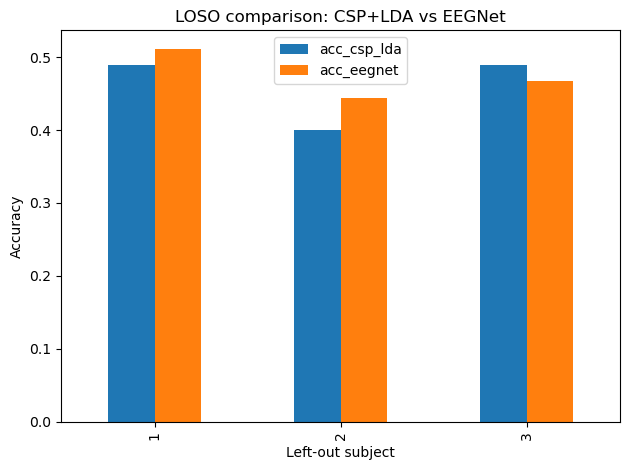

,left_out_subject,acc_csp_lda,acc_eegnet,best_params
0,1,0.488889,0.511111,"{'F1': 32, 'D': 1, 'dropout': 0.45326550568397..."
1,2,0.400000,0.444444,"{'F1': 8, 'D': 4, 'dropout': 0.287948335987449..."
2,3,0.488889,0.466667,"{'F1': 32, 'D': 4, 'dropout': 0.69638560275773..."


In [10]:

if not results_df.empty:
    ax = results_df.set_index("left_out_subject")[["acc_csp_lda","acc_eegnet"]].plot(kind="bar")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Left-out subject")
    ax.set_title("LOSO comparison: CSP+LDA vs EEGNet")
    plt.tight_layout()
    plt.show()
results_df


In [14]:
pd.set_option('display.max_colwidth', None)

In [16]:
results_df

,left_out_subject,acc_csp_lda,acc_eegnet,best_params
0,1,0.488889,0.511111,"{'F1': 32, 'D': 1, 'dropout': 0.45326550568397994, 'lr': 0.0005310229292330667, 'batch_size': 64}"
1,2,0.400000,0.444444,"{'F1': 8, 'D': 4, 'dropout': 0.2879483359874494, 'lr': 0.0019704837498947347, 'batch_size': 16}"
2,3,0.488889,0.466667,"{'F1': 32, 'D': 4, 'dropout': 0.6963856027577339, 'lr': 0.000612197660938815, 'batch_size': 64}"
